# Introduction


## **The objective** 
To predict which type of customers would have a risk of being default 

## Datasets and Features
**Default Customer** : if a customer does not pay due amount in 120 days after the latest statement date

##


# Library

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
warnings.filterwarnings("ignore")

# Import Dataset
- parquet file :train_data, test_data
- pickle file: train_labels

In [2]:
train = pd.read_parquet('train_data.parquet', engine='fastparquet')
test = pd.read_parquet('test_data.parquet', engine='fastparquet')
labels = pd.read_pickle('train_labels.pkl')
train.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,...,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,...,NaN,NaN,0.003954,0.003167,0.005032,NaN,0.009576,0.005492,0.009217,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,0.009423,...,NaN,NaN,0.003269,0.007329,0.000427,NaN,0.003429,0.006986,0.002603,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,0.005531,...,NaN,NaN,0.006117,0.004516,0.003200,NaN,0.008419,0.006527,0.009600,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,0.009312,...,NaN,NaN,0.003671,0.004946,0.008889,NaN,0.001670,0.008126,0.009827,0


# EDA

## Categorical Features

In [30]:
categorical_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68','target']
date_cols = ['S_2']

<AxesSubplot:>

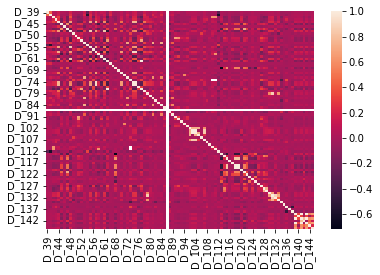

In [16]:
sns.heatmap(train.loc[:,D_col_list].corr())

<Figure size 2160x1440 with 0 Axes>

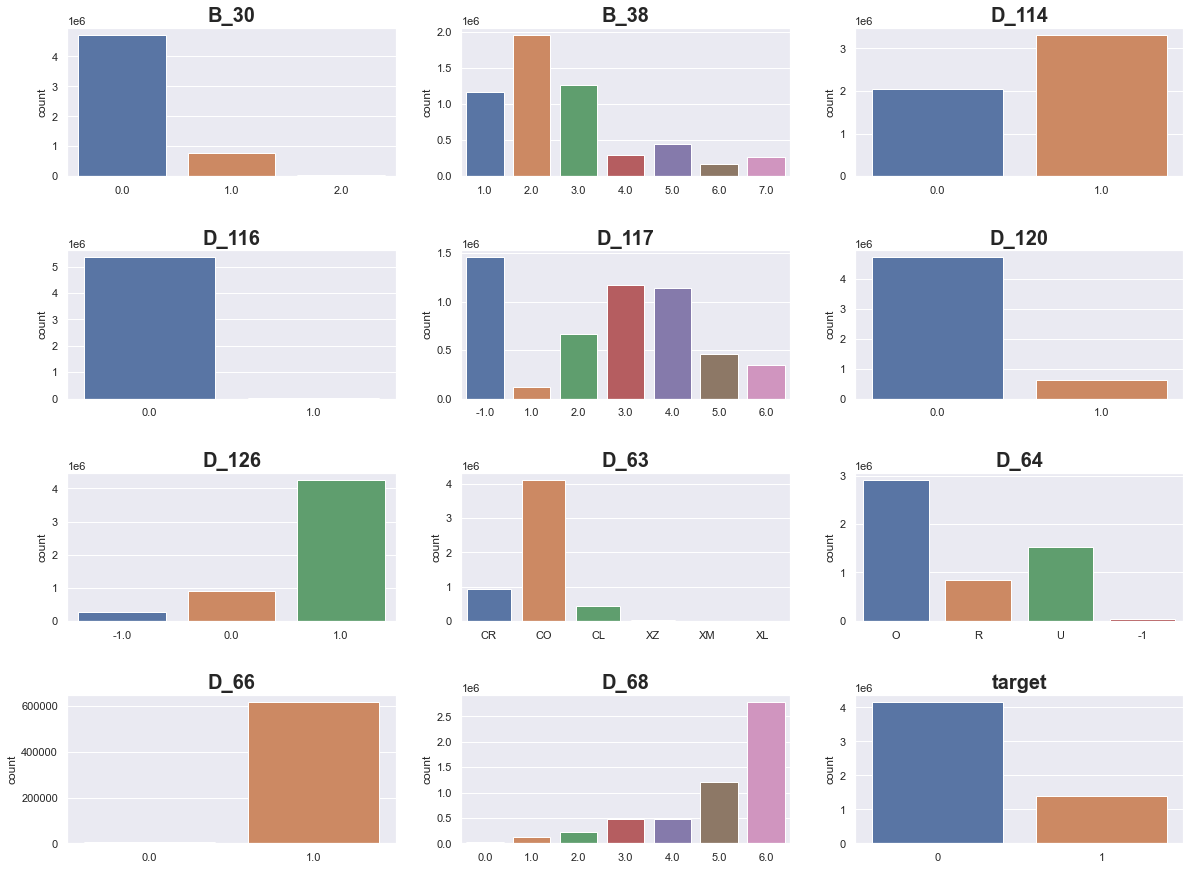

In [45]:
import itertools

plt.figure(figsize = (30,20))
plt.subplots(figsize = (20,15))
# # age_pro = pd.crosstab(pro['Age'], pro['RegroupJobTitle'])
# # age_nonpro = pd.crosstab(nonpro['Age'], nonpro['RegroupJobTitle'])
# category = ['DS','DA','DE','OTHER']
categorical_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68','target']
date_cols = ['S_2']

length = len(categorical_cols)

sns.set_theme(style="darkgrid") # '#0A174E', '#F5D042'

for i, j in itertools.zip_longest(categorical_cols, range(length)):
    plt.subplot( (length/3), 3, j+1) # nrows, ncols, index
    plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
    sns.countplot(data = train, x = i)
  
#     age_nonpro[i].plot.bar(color = '#D4C8BE')
    plt.title(i, size = 20, weight = 'bold')
    plt.xlabel('')
plt.show()

As the above shows, there are 3 binary feautres except for target and the most of them contiains more than 2 values. 

## Insights
- Both **D_116** and **D_66** seems to be extremely imbalanced, which can be said they have meaningless information. (Useless)
- Although **D_120** is not as much imbalanced as D_116 and D_66, it needs to be investigated if there is correlated to **target**
- Unlike non-binary features, **B_30** seems to convey binary information
- Some categorical features needs to be redesignated or reduced its dimention since there are not enough information especailly **D_63**, **D_64** and **D_68**

Let's dive into these features deaply!

In [57]:
default_ratio = 100 * round(train['target'].sum()/train.shape[0],4)
print(f'The default customer ratio is {default_ratio}%')

The default customer ratio is 24.91%


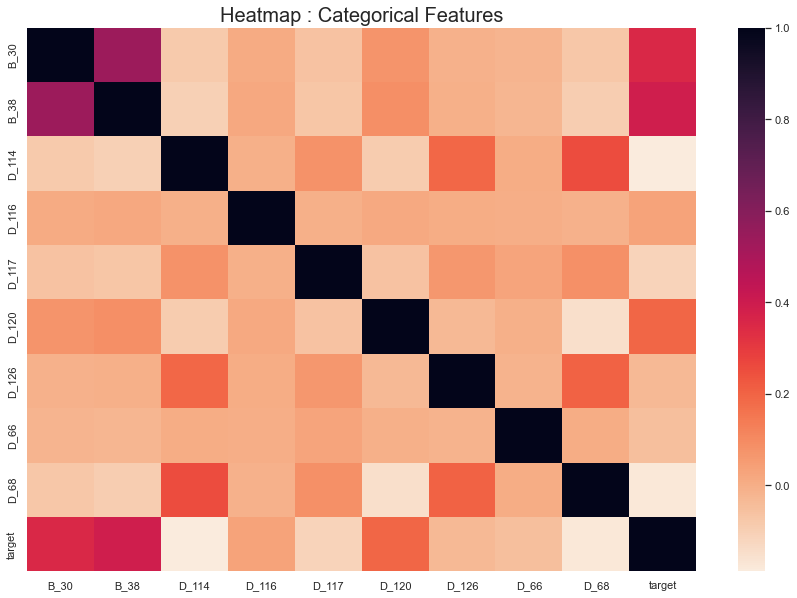

In [54]:
plt.figure(figsize = (15,10))

cmap = sns.color_palette("rocket_r", as_cmap=True)
sns.heatmap(train.loc[:, categorical_cols].corr(), cmap = cmap)

plt.title('Heatmap : Categorical Features', fontdict = {'size': 20})
plt.show()

## Insights
### Correlation to Target
- Strong Relationship
    - **B_30** & **B_38**
- Minimal Relationship 
    - **D_120**

In [46]:
train.columns

Index(['customer_ID', 'S_2', 'P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41',
       'B_3',
       ...
       'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143', 'D_144',
       'D_145', 'target'],
      dtype='object', length=191)

## Numercial Features

In [88]:
columns_list = train.columns.tolist()
D_col_list = []
for col in columns_list:
    if col.startswith('D') ==True:
        D_col_list.append(col)
print('Delinquency variables :',len(D_col_list))
D_na_features = (train.loc[:,D_col_list].isna().sum() > 0).sum()
print(f'The number of features containing NA values : {D_na_features}')

Delinquency variables : 96
The number of features containing NA values : 81


In [89]:
D_numeric_list = D_col_list.copy()
for D_cat in categorical_cols:
    if D_cat.startswith('D'):
        D_numeric_list.remove(D_cat)
D_numeric_list

['D_39',
 'D_41',
 'D_42',
 'D_43',
 'D_44',
 'D_45',
 'D_46',
 'D_47',
 'D_48',
 'D_49',
 'D_50',
 'D_51',
 'D_52',
 'D_53',
 'D_54',
 'D_55',
 'D_56',
 'D_58',
 'D_59',
 'D_60',
 'D_61',
 'D_62',
 'D_65',
 'D_69',
 'D_70',
 'D_71',
 'D_72',
 'D_73',
 'D_74',
 'D_75',
 'D_76',
 'D_77',
 'D_78',
 'D_79',
 'D_80',
 'D_81',
 'D_82',
 'D_83',
 'D_84',
 'D_86',
 'D_87',
 'D_88',
 'D_89',
 'D_91',
 'D_92',
 'D_93',
 'D_94',
 'D_96',
 'D_102',
 'D_103',
 'D_104',
 'D_105',
 'D_106',
 'D_107',
 'D_108',
 'D_109',
 'D_110',
 'D_111',
 'D_112',
 'D_113',
 'D_115',
 'D_118',
 'D_119',
 'D_121',
 'D_122',
 'D_123',
 'D_124',
 'D_125',
 'D_127',
 'D_128',
 'D_129',
 'D_130',
 'D_131',
 'D_132',
 'D_133',
 'D_134',
 'D_135',
 'D_136',
 'D_137',
 'D_138',
 'D_139',
 'D_140',
 'D_141',
 'D_142',
 'D_143',
 'D_144',
 'D_145']

In [ ]:
import itertools

plt.figure(figsize = (40,30))
plt.subplots(figsize = (20,15))
# # age_pro = pd.crosstab(pro['Age'], pro['RegroupJobTitle'])
# # age_nonpro = pd.crosstab(nonpro['Age'], nonpro['RegroupJobTitle'])
# category = ['DS','DA','DE','OTHER']

length = len(D_numeric_list)

sns.set_theme(style="darkgrid") # '#0A174E', '#F5D042'
bins = round(train.shape[0]/10)
for i, j in itertools.zip_longest(D_numeric_list, range(length)):
    plt.subplot( (length/3), 3, j+1) # nrows, ncols, index
    plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
    plt.hist(train[i], kde = True, bins = 1000)
  
#     age_nonpro[i].plot.bar(color = '#D4C8BE')
    plt.title(i, size = 20, weight = 'bold')
    plt.xlabel('')
plt.show()

In [ ]:
 ncols = 4
 bins = round(train.shape[0]/10)
 for i, j in enumerate(D_numeric_list):
    if i % ncols == 0: 
        if i > 0: plt.show()
        plt.figure(figsize=(16, 5))
        if i == 0: plt.suptitle('Numerical features', fontsize=20, y=1.02, weight = 'bold')
    plt.subplot(1, ncols, i % ncols + 1)
    plt.hist(train[j], bins=bins)
    plt.title(j, size = 15, weight = 'bold')
    plt.xlabel(j)
plt.show()